In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import label_binarize
from sklearn import metrics

In [2]:
mpl.rcParams['font.sans-serif'] = [u'SimHei']
mpl.rcParams['axes.unicode_minus'] = False

In [3]:
names = [u'Age', u'Number of sexual partners', u'First sexual intercourse',
       u'Num of pregnancies', u'Smokes', u'Smokes (years)',
       u'Smokes (packs/year)', u'Hormonal Contraceptives',
       u'Hormonal Contraceptives (years)', u'IUD', u'IUD (years)', u'STDs',
       u'STDs (number)', u'STDs:condylomatosis',
       u'STDs:cervical condylomatosis', u'STDs:vaginal condylomatosis',
       u'STDs:vulvo-perineal condylomatosis', u'STDs:syphilis',
       u'STDs:pelvic inflammatory disease', u'STDs:genital herpes',
       u'STDs:molluscum contagiosum', u'STDs:AIDS', u'STDs:HIV',
       u'STDs:Hepatitis B', u'STDs:HPV', u'STDs: Number of diagnosis',
       u'STDs: Time since first diagnosis', u'STDs: Time since last diagnosis',
       u'Dx:Cancer', u'Dx:CIN', u'Dx:HPV', u'Dx', u'Hinselmann', u'Schiller',
       u'Citology', u'Biopsy']#df.columns
path = "datas/risk_factors_cervical_cancer.csv"  # 数据文件路径
data = pd.read_csv(path)

In [4]:
## 模型存在多个需要预测的y值，如果是这种情况下，简单来讲可以直接模型构建，在模型内部会单独的处理每个需要预测的y值，相当于对每个y创建一个模型
X = data[names[0:-4]]
Y = data[names[-4:]]
X.head(1)#随机森林可以处理多个目标变量的情况

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs:HIV,STDs:Hepatitis B,STDs:HPV,STDs: Number of diagnosis,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,?,?,0,0,0,0


In [5]:
#空值的处理
X = X.replace("?", np.NAN)
# 使用Imputer给定缺省值，默认的是以mean
# 对于缺省值，进行数据填充；默认是以列/特征的均值填充
imputer = Imputer(missing_values="NaN")
X = imputer.fit_transform(X, Y)

In [6]:
X[0]

array([ 18.        ,   4.        ,  15.        ,   1.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   6.14084507,   5.81690141,
         0.        ,   0.        ,   0.        ,   0.        ])

In [7]:
#数据分割
x_train,x_test,y_train,y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
print ("训练样本数量:%d,特征属性数目:%d,目标属性数目:%d" % (x_train.shape[0],x_train.shape[1],y_train.shape[1]))
print ("测试样本数量:%d" % x_test.shape[0])

训练样本数量:686,特征属性数目:32,目标属性数目:4
测试样本数量:172


In [8]:
#标准化
ss = MinMaxScaler()#分类模型，经常使用的是minmaxscaler归一化，回归模型经常用standardscaler
x_train = ss.fit_transform(x_train, y_train)
x_test = ss.transform(x_test)
x_train.shape

(686, 32)

In [9]:
#降维
pca = PCA(n_components=2)
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)
x_train.shape
print(pca.explained_variance_ratio_)

[ 0.24021831  0.2067443 ]


In [10]:
#随机森林模型
### n_estimators：迭代次数，每次迭代为Y产生一个模型
forest = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=2, random_state=0)
forest.fit(x_train, y_train)#max_depth一般不宜设置过大，把每个模型作为一个弱分类器

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [11]:
#模型效果评估
score = forest.score(x_test, y_test)
print("准确率:%.2f%%" % (score * 100))

准确率:89.53%


In [12]:
# 预测概率值
forest_y_score = forest.predict_proba(x_test)# prodict_proba输出概率
print("预测概率的结构为:{}".format(np.array(forest_y_score).shape))

预测概率的结构为:(4, 172, 2)


In [14]:
#模型效果评估
score = forest.score(x_test, y_test)
print ("准确率:%.2f%%" % (score * 100))
#模型预测
forest_y_score = forest.predict_proba(x_test)# prodict_proba输出概率
#计算ROC值
forest_fpr1, forest_tpr1, _ = metrics.roc_curve(label_binarize(y_test[names[-4]],classes=(0,1,2)).T[0:-1].T.ravel(), forest_y_score[0].ravel())
forest_fpr2, forest_tpr2, _ = metrics.roc_curve(label_binarize(y_test[names[-3]],classes=(0,1,2)).T[0:-1].T.ravel(), forest_y_score[1].ravel())
forest_fpr3, forest_tpr3, _ = metrics.roc_curve(label_binarize(y_test[names[-2]],classes=(0,1,2)).T[0:-1].T.ravel(), forest_y_score[2].ravel())
forest_fpr4, forest_tpr4, _ = metrics.roc_curve(label_binarize(y_test[names[-1]],classes=(0,1,2)).T[0:-1].T.ravel(), forest_y_score[3].ravel())
#AUC值
auc1 = metrics.auc(forest_fpr1, forest_tpr1)
auc2 = metrics.auc(forest_fpr2, forest_tpr2)
auc3 = metrics.auc(forest_fpr3, forest_tpr3)
auc4 = metrics.auc(forest_fpr4, forest_tpr4)

print ("Hinselmann目标属性AUC值：", auc1)
print ("Schiller目标属性AUC值：", auc2)
print ("Citology目标属性AUC值：", auc3)
print ("Biopsy目标属性AUC值：", auc4)

准确率:89.53%
Hinselmann目标属性AUC值： 0.990569226609
Schiller目标属性AUC值： 0.965319091401
Citology目标属性AUC值： 0.962074094105
Biopsy目标属性AUC值： 0.961026230395


In [16]:
# 正确的数据
y_true = label_binarize(y_test[names[-4]],classes=(0,1,2)).T[0:-1].T.ravel()
# 预测的数据 => 获取第一个目标属性的预测值，并将其转换为一维的数组
y_predict = forest_y_score[0].ravel()
# 计算的值
metrics.roc_curve(y_true, y_predict)

(array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.00581395,  0.00581395,
         0.00581395,  0.00581395,  0.00581395,  0.00581395,  0.00581395,
         0.00581395,  0.00581395,  0.00581395,  0.00581395,  0.00581395,
         0.00581395,  0.00581395,  0.01162791,  0.01162791,  0.01162791,
         0.01162791,  0.01162791,  0.01162791,  0.01162791,  0.01162791,
         0.02325581,  0.04069767,  0.12790698,  0.14534884,  0.16860465,
         0.18023256,  0.18604651,  0.20930233,  0.24418605,  0.26744186,
         0.29069767,  0.29651163,  0.33139535,  0.36046512,  0.37209302,
         0.4127907 ,  0.41860465,  0.51744186,  0.52906977,  0.55232558,
         0.56395349,  0.68604651,  0.72093023,  0.81395349,  0.8255814 ,
         0.95348837,  0.96511628,  0.97093023,  0.98255814,  1.        ]),
 array([ 0.01744186,  0.02906977,  0.03488372,  0.04651163,  0.1744186 ,
         0.18604651,  0.27906977,  0.31395349,  0

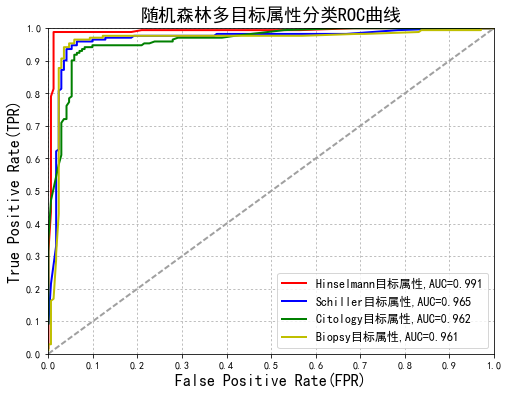

In [17]:
## 8. 画图（ROC图）
plt.figure(figsize=(8, 6), facecolor='w')
plt.plot(forest_fpr1,forest_tpr1,c='r',lw=2,label=u'Hinselmann目标属性,AUC=%.3f' % auc1)
plt.plot(forest_fpr2,forest_tpr2,c='b',lw=2,label=u'Schiller目标属性,AUC=%.3f' % auc2)
plt.plot(forest_fpr3,forest_tpr3,c='g',lw=2,label=u'Citology目标属性,AUC=%.3f' % auc3)
plt.plot(forest_fpr4,forest_tpr4,c='y',lw=2,label=u'Biopsy目标属性,AUC=%.3f' % auc4)
plt.plot((0,1),(0,1),c='#a0a0a0',lw=2,ls='--')
plt.xlim(-0.001, 1.001)
plt.ylim(-0.001, 1.001)
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel('False Positive Rate(FPR)', fontsize=16)
plt.ylabel('True Positive Rate(TPR)', fontsize=16)
plt.grid(b=True, ls=':')
plt.legend(loc='lower right', fancybox=True, framealpha=0.8, fontsize=12)
plt.title(u'随机森林多目标属性分类ROC曲线', fontsize=18)
plt.show()

训练样本数量429，测试样本数量:429
1决策树数目，1最大深度，正确率:88.11%
1决策树数目，2最大深度，正确率:88.11%
1决策树数目，3最大深度，正确率:87.88%
1决策树数目，7最大深度，正确率:85.78%
1决策树数目，15最大深度，正确率:74.36%
50决策树数目，1最大深度，正确率:88.11%
50决策树数目，2最大深度，正确率:88.11%
50决策树数目，3最大深度，正确率:86.95%
50决策树数目，7最大深度，正确率:86.95%
50决策树数目，15最大深度，正确率:86.48%
100决策树数目，1最大深度，正确率:88.11%
100决策树数目，2最大深度，正确率:88.11%
100决策树数目，3最大深度，正确率:86.95%
100决策树数目，7最大深度，正确率:86.71%
100决策树数目，15最大深度，正确率:86.48%
500决策树数目，1最大深度，正确率:88.11%
500决策树数目，2最大深度，正确率:88.11%
500决策树数目，3最大深度，正确率:86.95%
500决策树数目，7最大深度，正确率:86.95%
500决策树数目，15最大深度，正确率:86.71%


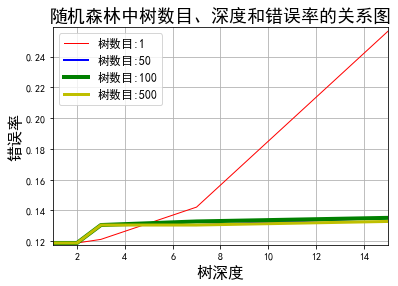

In [22]:
#比较不同树数目、树最大深度的情况下随机森林的正确率
#一般情况下，初始的随机森林树个数是100，深度1，如果需要我们再进行优化操作
x_train2,x_test2,y_train2,y_test2 = train_test_split(X, Y, test_size=0.5, random_state=0)
print ("训练样本数量%d，测试样本数量:%d" % (x_train2.shape[0], x_test2.shape[0]))
## 比较
estimators = [1,50,100,500]
depth = [1,2,3,7,15]
err_list = []
for es in estimators:
    es_list = []
    for d in depth:
        tf = RandomForestClassifier(n_estimators=es, criterion='gini', max_depth=d, random_state=0)
        tf.fit(x_train2, y_train2)
        st = tf.score(x_test2, y_test2)
        err = 1 - st
        es_list.append(err)
        print ("%d决策树数目，%d最大深度，正确率:%.2f%%" % (es, d, st * 100))
    err_list.append(es_list)

    
## 画图
plt.figure(facecolor='w')
i = 0
colors = ['r','b','g','y']
lw = [1,2,4,3]
max_err = 0
min_err = 100
for es,l in zip(estimators,err_list):
    plt.plot(depth, l, c=colors[i], lw=lw[i], label=u'树数目:%d' % es)
    max_err = max((max(l),max_err))
    min_err = min((min(l),min_err))
    i += 1
plt.xlabel(u'树深度', fontsize=16)
plt.ylabel(u'错误率', fontsize=16)
plt.legend(loc='upper left', fancybox=True, framealpha=0.8, fontsize=12)
plt.grid(True)
plt.xlim(min(depth),max(depth))
plt.ylim(min_err * 0.99, max_err * 1.01)
plt.title(u'随机森林中树数目、深度和错误率的关系图', fontsize=18)
plt.show()

In [23]:
# 随机森林画图
# 方式三：直接生成图片
from sklearn import tree
from IPython.display import Image  
import pydotplus
k = 0
for clf in forest.estimators_:
    dot_data = tree.export_graphviz(clf, out_file=None,  
                         filled=True, rounded=True,  
                         special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data)
#     graph.write_pdf("foress_tree_%d.pdf" % k)
    graph.write_png("foress_tree_%d.png" % k)
    k += 1
    if k >= 10:
        break